In [69]:
# Importing important libraries

import optuna
import joblib
import numpy as np
import pandas as pd
import lightgbm
import optuna.integration.lightgbm as optuna_lgb

from collections import OrderedDict
from sklearn.model_selection import ParameterGrid

In [114]:

df = pd.read_csv('training_set_VU_DM.csv')
df = df.drop('date_time', axis=1)

In [115]:
from sklearn.model_selection import train_test_split

df['target']= np.where((df['booking_bool'] == 1), 5, np.where((df['click_bool'] ==1) & (df['booking_bool'] == 0), 1, 0))
df = df.iloc[:10000]
train, test = train_test_split(df, test_size=0.2)
df

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,target
0,1,12,187,NaN,NaN,219,893,3,3.5,1,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,0
1,1,12,187,NaN,NaN,219,10404,4,4.0,1,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,0
2,1,12,187,NaN,NaN,219,21315,3,4.5,1,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,0
3,1,12,187,NaN,NaN,219,27348,2,4.0,1,...,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0,0
4,1,12,187,NaN,NaN,219,29604,4,3.5,1,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,703,5,219,NaN,NaN,219,78064,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0
9996,703,5,219,NaN,NaN,219,79720,3,3.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0
9997,703,5,219,NaN,NaN,219,94363,3,4.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0
9998,703,5,219,NaN,NaN,219,96276,2,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0


In [116]:
# Creating a numpy array which contains group
qids_train = train.groupby("srch_id")["srch_id"].count().to_numpy()
# Keeping only the features on which we would train our model 
X_train = train.drop(["click_bool", 'booking_bool', 'target', 'position', 'gross_bookings_usd'], axis = 1)
# Relevance label for train
y_train = train['target']

# Creating a numpy array which contains eval_group
qids_test = test.groupby("srch_id")["srch_id"].count().to_numpy()
# Keeping only the features on which we would validate our model
X_test = test.drop(["click_bool", 'booking_bool', 'target', 'position', 'gross_bookings_usd'], axis = 1)
# Relevance label for test
y_test = test['target']

In [117]:
# Creating the ranker object
ranker = lightgbm.LGBMRanker(
                    objective="lambdarank",
                    boosting_type = "gbdt",
                    n_estimators = 20,
                    importance_type = "gain",
                    metric= "ndcg",
                    num_leaves = 50,
                    learning_rate = 0.05,
                    max_depth = -1,
                    label_gain =[i for i in range(max(y_train.max(), y_test.max()) + 1)])

# Training the model
ranker.fit(
      X=X_train,
      y=y_train,
      group=qids_train,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[qids_train, qids_test],
      eval_at=[5])

[1]	training's ndcg@5: 0.732874	valid_1's ndcg@5: 0.922896
[2]	training's ndcg@5: 0.820361	valid_1's ndcg@5: 0.927275
[3]	training's ndcg@5: 0.871243	valid_1's ndcg@5: 0.925882
[4]	training's ndcg@5: 0.887529	valid_1's ndcg@5: 0.927645
[5]	training's ndcg@5: 0.901193	valid_1's ndcg@5: 0.927707
[6]	training's ndcg@5: 0.912983	valid_1's ndcg@5: 0.928185
[7]	training's ndcg@5: 0.919936	valid_1's ndcg@5: 0.92657
[8]	training's ndcg@5: 0.924942	valid_1's ndcg@5: 0.928152
[9]	training's ndcg@5: 0.930855	valid_1's ndcg@5: 0.9264
[10]	training's ndcg@5: 0.93786	valid_1's ndcg@5: 0.926205
[11]	training's ndcg@5: 0.93961	valid_1's ndcg@5: 0.927183
[12]	training's ndcg@5: 0.946956	valid_1's ndcg@5: 0.928902
[13]	training's ndcg@5: 0.949318	valid_1's ndcg@5: 0.928294
[14]	training's ndcg@5: 0.95138	valid_1's ndcg@5: 0.929453
[15]	training's ndcg@5: 0.953391	valid_1's ndcg@5: 0.928704
[16]	training's ndcg@5: 0.956206	valid_1's ndcg@5: 0.928489
[17]	training's ndcg@5: 0.958263	valid_1's ndcg@5: 0.92

LGBMRanker(importance_type='gain', label_gain=[0, 1, 2, 3, 4, 5],
           learning_rate=0.05, metric='ndcg', n_estimators=20, num_leaves=50,
           objective='lambdarank')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

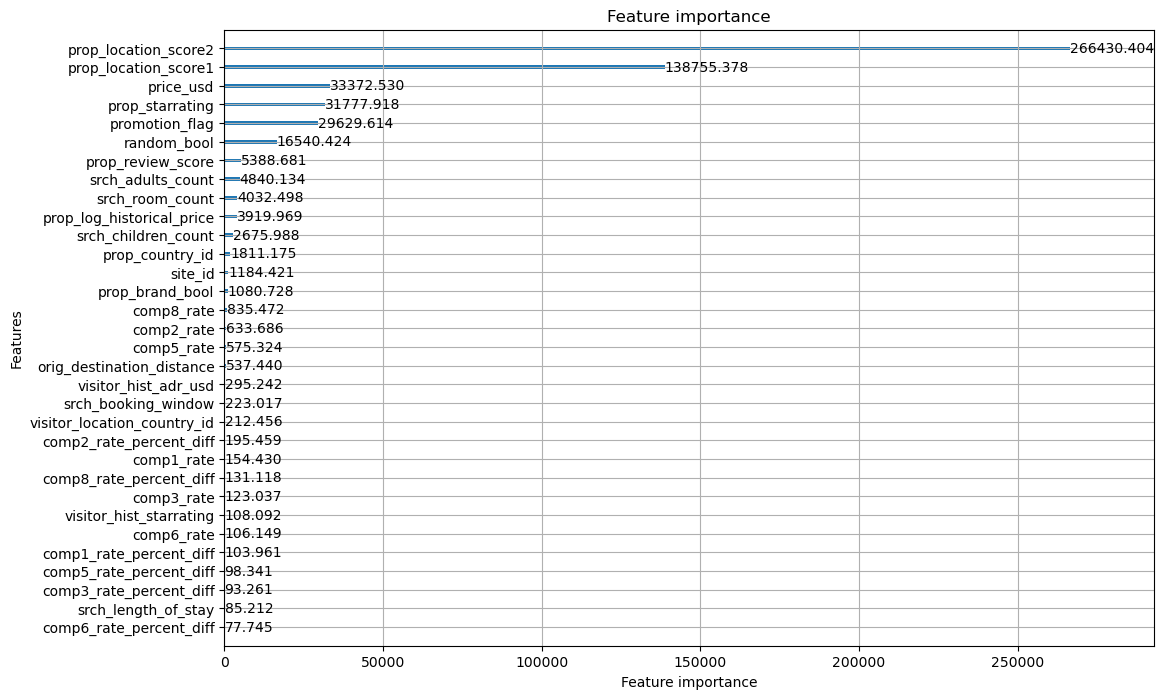

In [108]:

lightgbm.plot_importance(ranker, figsize = (12,8))